# Flujo estándar

Cada vez que se desea trabajar con las señales de los sismómetros, se debe aplicar una serie de operaciones. En procesamiento digital de señales, esto se conoce como pre-procesamiento. Tiene como fin de ajustar las señales a los requerimientos del sistema, separar la información relevante del resto, disminuir el ruído, entre otras. 

Lo pasos básicos son:

- Ajustar el `sample rate` de todos los `traces` al mismo valor. En general es útil si se van a aplicar operaciones entre ellos, por ejemplo, calcular una cross-correlación. 
- Solucionar los *huecos* con operaciones `.merge()`.
- Ajustar la longitud de la señal con `.trim()`.
- Remover la línea de tendencia con `.detrend()`.
- Remover la respuesta del instrumento con `.remove_response()`. En Obspy, esta función puede tambien remover la media. 
- Filtrar la señal a la banda deseada utilizando `.filter()`. 

El siguiente código aplica los pasos necesarios del flujo a la señal del sismómetro de Jacó:

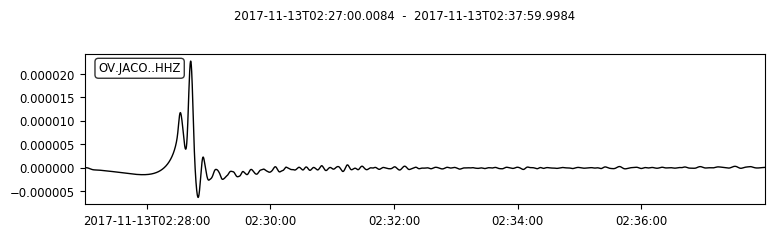

In [1]:
import obspy 

# Carga la señal a memoria
jaco_wave = obspy.read('datos/jaco-solo_jaco.tar.mseed')
jaco_wave.merge()

# Remueve la línea de tendencia
jaco_wave.detrend(type='linear')

# Carga el archivo con la respuesta del instrumento
resp = obspy.read_inventory('datos/jaco-solo_jaco.dataless')
# Remueve la respuesta del instrumento. Retorna el DESPlazamiento
jaco_wave.remove_response(inventory=resp, output='DISP', water_level=0)

# aplica un filtro paso-bajos a la señal, con frecuencia de corte 0.20 Hz
jaco_wave.filter('lowpass', freq=0.1)
jaco_wave.plot() 

### Ejercicio

Escriba una functión llamda `pre_process` que tome un objeto `Trace` y un objeto `Inventory` y aplique el pre-procesamiento típico. Añada un argumento `key-value` para la frecuencia de corte del filtro paso bajo. Utilice la función para procesar de nuevo la señal del sismómetro de Jacó. 

In [101]:
def pre_process(señal, inventario, freq=0.1):
    return señal

# Análisis en frecuencia

Analizar las señales en el dominio de la frecuencia es una actividad muy común. Obspy incluye el método `.spectrogram()`, que grafica el espectrograma de la señal. Esto es, una representación en tiempo y frecuencia de la señal. Puede encontrar la documentación de la función [aquí](https://docs.obspy.org/packages/autogen/obspy.imaging.spectrogram.spectrogram.html#obspy.imaging.spectrogram.spectrogram).

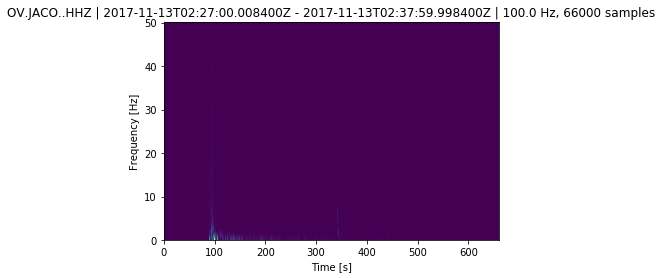

[None]

In [82]:
# Preprocesar la señal con un filtro poco discriminante

jaco_wave = obspy.read('datos/jaco-solo_jaco.tar.mseed')
resp = obspy.read_inventory('datos/jaco-solo_jaco.dataless')

jaco_wave = pre_process(jaco_wave, resp, freq=100)

jaco_wave.spectrogram()

La función `.spectrogram()` es útil para darse una idea rápida de la señal. Sin embargo, si queremos aplicar nuestros propios análisis, debemos utilizar Numpy junto con Matplotlib. Por ejemplo, podemos calcular la Tansformada de Fourier del sismo y observar con más detalle como se distribuye en la frecuencia:

[  9.65711056e+08 +0.00000000e+00j  -5.19530751e+09 -2.55060082e+09j
  -8.92689028e+09 +7.41463742e+09j ...,   6.89870125e+04 +2.95150957e+02j
   6.92210700e+04 +2.15917579e+02j   6.93760000e+04 +0.00000000e+00j]


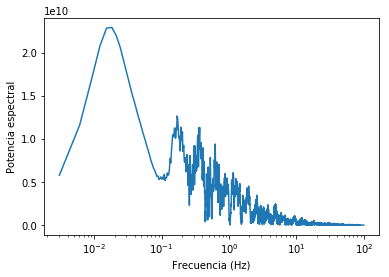

In [74]:
import numpy as np
import matplotlib.pyplot as plt

jaco_fft = np.fft.rfft(jaco_wave[0].data)
print(jaco_fft)
freq = np.array([i * jaco_wave[0].stats['sampling_rate'] / len(jaco_fft) for i in range(len(jaco_fft))])
plt.semilogx(freq, np.absolute(jaco_fft))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia espectral')

plt.show()

¡Aparecen cosas interesantes! Por ejemplo:

- La mayor parte de la energía de la señal está en las frecuencias bajas.
- La señal parece estar compuesta de armónicos. 
- La razón señal a ruido empeora al aumentar la frecuencia.

Además, parece ser una señal compuesta por funciones simples. Un seno para la oscilación, una exponencial negativa para hacer decaer la amplitud y una recta. ¿Qué tal ajustar la curva por inspección? 

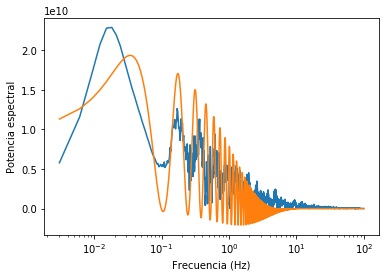

In [83]:
# Curva original
plt.semilogx(freq, np.absolute(jaco_fft))
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia espectral')

# Por inspección
match = (1e10 * np.sin(45*freq) + 1e10 - 0.4e10 * freq) * np.exp(-0.7*freq)
plt.semilogx(freq, match)

plt.show()

Pasando de la frecuencia al tiempo:

- Un exponencial sigue siendo un exponencial.
- El seno es un impulso. 
- La recta es una función paso.

Este *tanteo* en la frecuencia nos dice que en el tiempo, la señal la produce algo parecido a una explosión. 

# Transformada Wavelet continua

El espectrograma nos permite visualizar como cambia el espectro de la señal en el tiempo. En ese sentido, la transformada wavelet nos permite hacer lo mismo, sin embargo, esta tiene mejor resolución espacial y temporal. 
El código a continuación calcula la transformada wavelet del sismo de Jacó. 

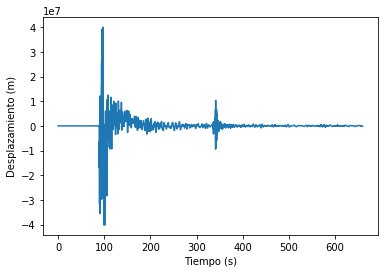

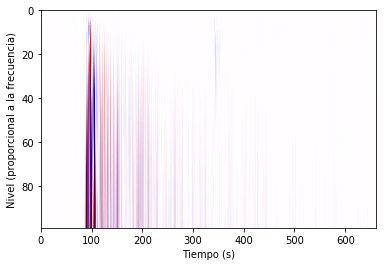

In [105]:
from scipy import signal
import matplotlib.pyplot as plt 
import numpy as np 

jaco_wave = obspy.read('datos/jaco-solo_jaco.tar.mseed')
resp = obspy.read_inventory('datos/jaco-solo_jaco.dataless')

jaco_wave = pre_process(jaco_wave, resp, freq=100) 
plt.plot(np.linspace(0,660, len(jaco_wave[0].data)), jaco_wave[0].data)
plt.xlabel('Tiempo (s)')
plt.ylabel('Desplazamiento (m)')
plt.show()

niveles = np.arange(1,100)
jaco_cwt = signal.cwt(jaco_wave[0].data, signal.ricker, niveles)
plt.imshow(jaco_cwt, aspect='auto', extent=[0,660,99,0], cmap='seismic', vmax=abs(jaco_cwt).max(), vmin=-abs(jaco_cwt).max())
plt.xlabel('Tiempo (s)')
plt.ylabel('Nivel (proporcional a la frecuencia)')
plt.show()

Observe ese evento alrededor de los $340 s$. También se puede observar en la transformada wavelet. Casi no tiene *componentes* de alta frecuencia ¿Será una réplica? 

Este tipo de análisis en tiempo-frecuencias es muy fácil de hacer utilizando la transformada wavelet. 